In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evallm
from automata.fa.dfa import DFA
import tqdm.auto as tqdm

In [3]:
import itertools
from permacache import stable_hash

In [4]:
from evallm.prompting.transducer_prompt import (
    ChainOfThoughtPromptRealExampleNoExplanation,
    BasicSequencePrompt,
    BasicSequencePromptSlightlyMoreExplanation,
    BasicSequencePromptNoChat,
    SequencePromptWithExplanation,
    SequencePromptWithExplanationChainOfThought,
    RedGreenRoomPrompt1,
)
from evallm.experiments.transducer_experiment import (
    current_transducer_experiments,
    compute_relative_to_null,
    compute_relative_to_ngram,
    print_example,
    bottom_quartile_outcome,
    current_dfa_sample_spec,
)
from evallm.experiments.transducer_plotting import (
    plot_all_absolute_results_single_graph,
    plot_absolute_results_barchart,
)

In [5]:
num_states_options_full = (3, 5, 7)

In [6]:
none = current_transducer_experiments(
    "none",
    num_states_options=num_states_options_full,
    num_dfas=1000,
    num_dfas_3_30=1000,
    num_sequence_symbol_options=range(30, 500 + 1, 10),
    just_stats=True,
)

In [7]:
def completion_model(k, m, count=1000):
    return {
        k: current_transducer_experiments(
            m,
            num_states_options=(3,),
            num_dfas=30,
            num_dfas_3_30=count,
            num_sequence_symbol_options=(30,),
            prompt=BasicSequencePromptNoChat.for_setting,
        )
    }

In [8]:
results = {
    # "llama3-8B + original prompt": current_transducer_experiments(
    #     "meta-llama/Meta-Llama-3-8B",
    #     num_states_options=num_states_options_full,
    #     num_dfas=30,
    #     num_sequence_symbol_options=(30, 60, 90, 120, 180, 240, 300, 400, 500),
    # ),
    "llama3-8B": current_transducer_experiments(
        "meta-llama/Meta-Llama-3-8B",
        num_states_options=num_states_options_full,
        # num_states_options=num_states_options_full[:1],
        num_dfas=30,
        num_dfas_3_30=1000,
        num_sequence_symbol_options=(30, 60, 90, 120, 180, 240, 300, 400, 500),
        # num_sequence_symbol_options=(30, 60, 90, 120, 180, 240),
        prompt=BasicSequencePromptNoChat.for_setting,
    ),
    **completion_model(
        "Mistral-NeMo-Minitron-8B", "nvidia/Mistral-NeMo-Minitron-8B-Base"
    ),
    # "llama3-8B-instruct": current_transducer_experiments(
    #     "meta-llama/Llama-3.1-8B-Instruct",
    #     num_states_options=(3,),
    #     num_dfas=30,
    #     num_dfas_3_30=1000,
    #     num_sequence_symbol_options=(30,),
    #     prompt=BasicSequencePromptNoChat.for_setting,
    # ),
    **completion_model("gemma-7b", "google/gemma-7b"),
    **completion_model("falcon-7b", "tiiuae/falcon-7b"),
    # "gpt-35-nonchat + original prompt": current_transducer_experiments(
    #     "gpt-3.5-turbo-instruct",
    #     num_dfas=30,
    #     num_states_options=num_states_options_full,
    #     num_sequence_symbol_options=(30, 120, 240, 300, 400),
    # ),
    "gpt-35-nonchat": current_transducer_experiments(
        "gpt-3.5-turbo-instruct",
        num_dfas=30,
        num_states_options=num_states_options_full[:1],
        num_sequence_symbol_options=(30, 120, 240, 300, 400),
        # num_sequence_symbol_options=(30, 120, 240),
        prompt=BasicSequencePromptNoChat.for_setting,
    ),
    "gpt-4o-mini": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-mini-2024-07-18",
        cot_prompt=BasicSequencePrompt.for_setting,
        num_states_options=num_states_options_full,
        num_sequence_symbol_options=(30, 120, 240, 500),
    ),
    "gpt-4o-mini + slightly more expl": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-mini-2024-07-18",
        cot_prompt=BasicSequencePromptSlightlyMoreExplanation.for_setting,
        num_states_options=num_states_options_full[:1],
        num_sequence_symbol_options=(30, 120, 240, 500)[:1],
    ),
    "gpt-4o-mini + red/green v1": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-mini-2024-07-18",
        cot_prompt=RedGreenRoomPrompt1.for_setting,
        num_states_options=num_states_options_full[:1],
        # num_sequence_symbol_options=(30, 120,),
        num_sequence_symbol_options=(30, 120, 240, 400),
    ),
    "gpt-4o-mini + explanation": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-mini-2024-07-18",
        cot_prompt=SequencePromptWithExplanation.for_setting,
        num_states_options=num_states_options_full,
        num_sequence_symbol_options=(30, 120, 240, 500),
    ),
    "gpt-4o-mini + explanation + cot": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-mini-2024-07-18",
        cot_prompt=SequencePromptWithExplanationChainOfThought.for_setting,
        num_states_options=num_states_options_full,
        num_sequence_symbol_options=(30, 120, 240, 500),
    ),
    "gpt-4o": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-2024-05-13",
        cot_prompt=BasicSequencePrompt.for_setting,
        num_states_options=num_states_options_full[:1],
        num_sequence_symbol_options=(30, 120, 240, 500),
        num_dfas_3_30=30,
    ),
    "claude-3.5": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "claude-3-5-sonnet-20241022",
        cot_prompt=BasicSequencePrompt.for_setting,
        num_states_options=num_states_options_full[:1],
        num_sequence_symbol_options=(30, 120, 240, 500)[:1],
    ),
    "claude-3.5 + slightly more expl": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "claude-3-5-sonnet-20241022",
        cot_prompt=BasicSequencePromptSlightlyMoreExplanation.for_setting,
        num_states_options=num_states_options_full[:1],
        num_sequence_symbol_options=(30, 120, 240, 500)[:1],
        num_dfas_3_30=100,
    ),
    "claude-3.5 + red/green v1": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "claude-3-5-sonnet-20241022",
        cot_prompt=RedGreenRoomPrompt1.for_setting,
        num_states_options=num_states_options_full[:1],
        num_sequence_symbol_options=(30, 120, 240, 500)[:1],
        num_dfas_3_30=30,
    ),
}

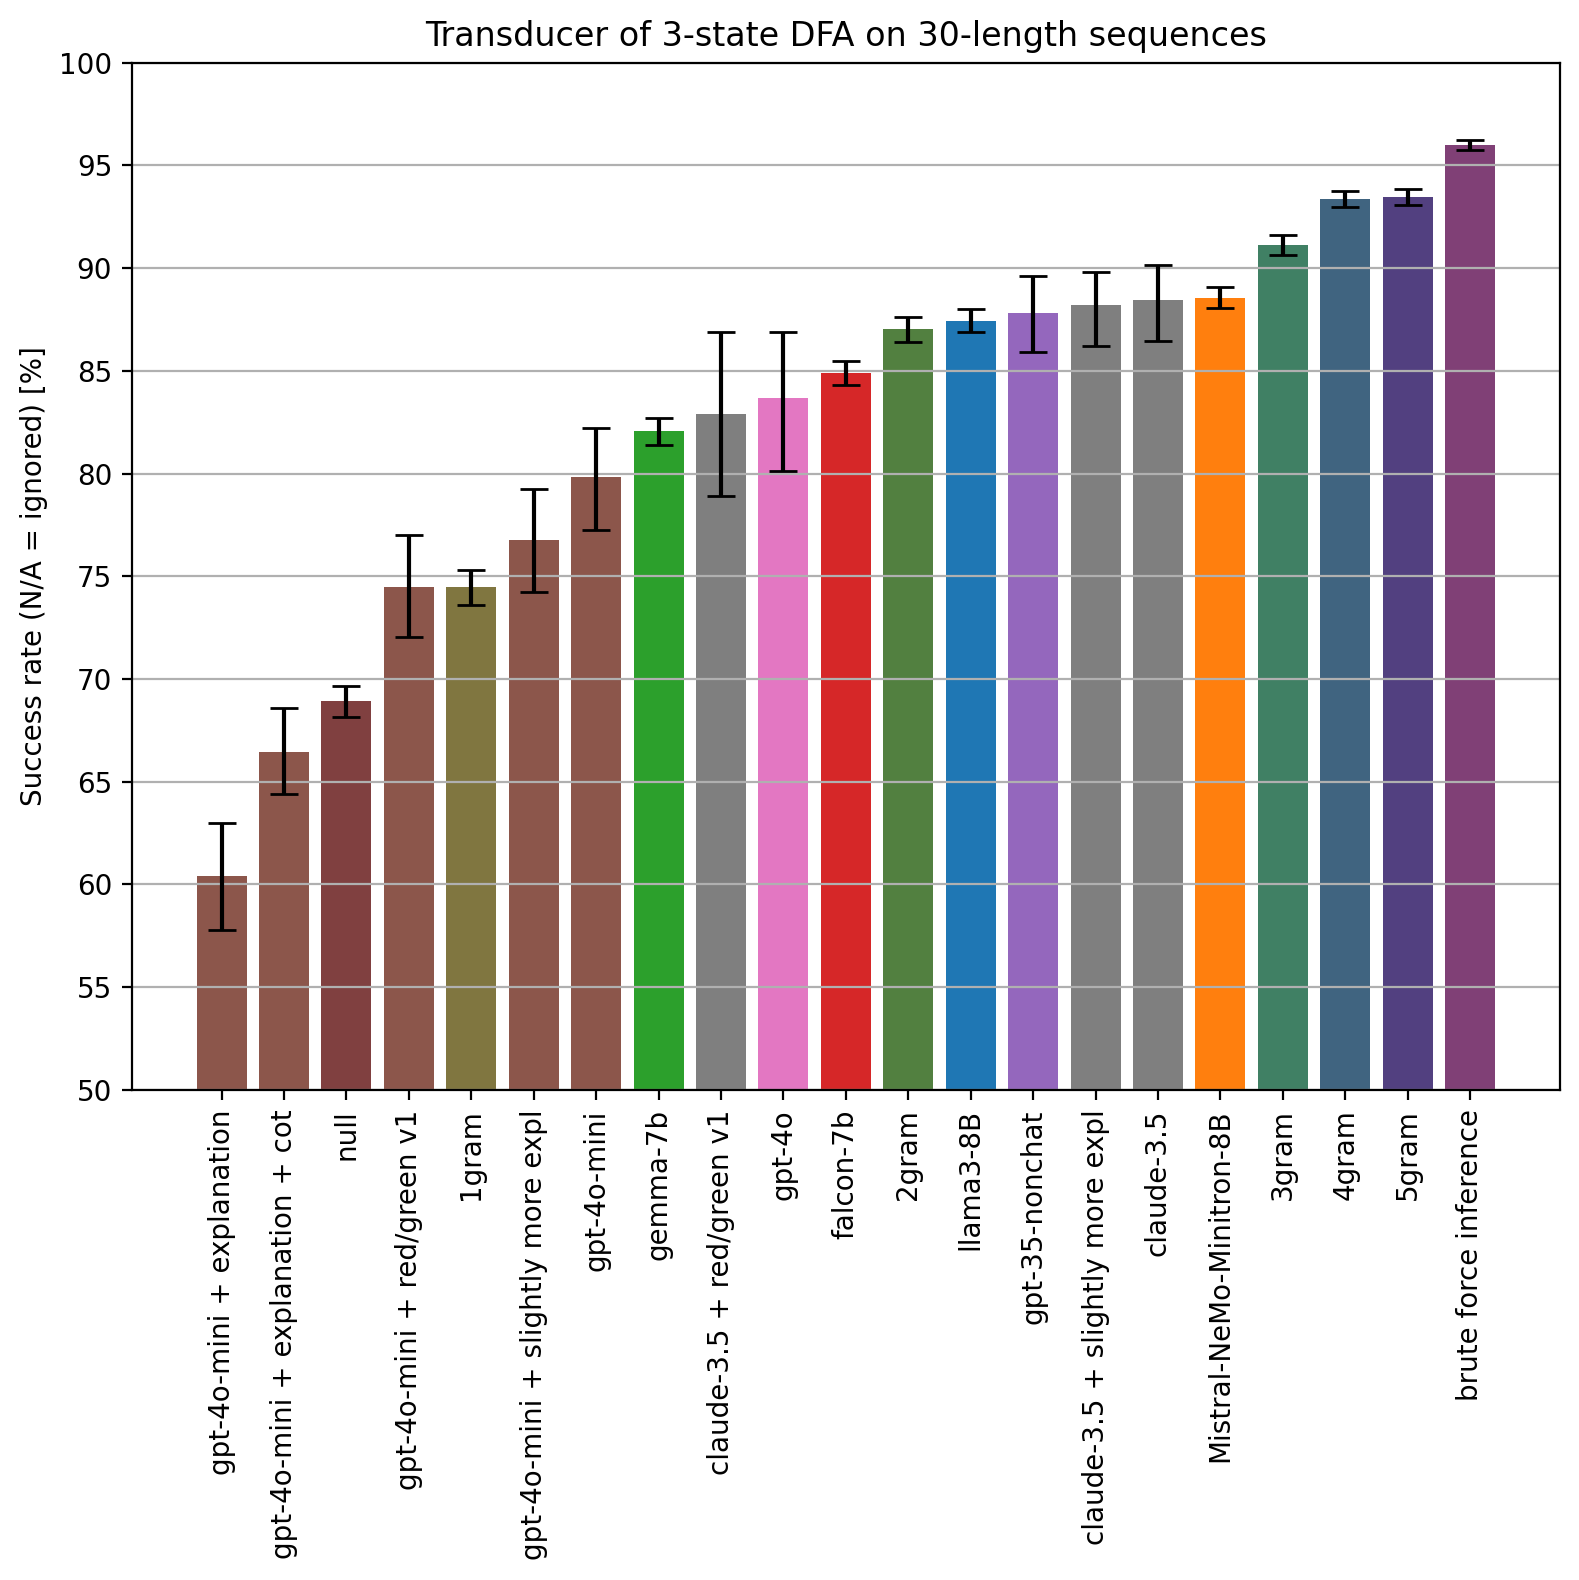

In [9]:
plot_absolute_results_barchart(results, none, 3, 30, ignore_na="na_ignore")

In [10]:
# plot_all_absolute_results_single_graph(results, none, 3, ignore_na="na_ignore")

In [11]:
# plot_all_absolute_results_single_graph(results, none, 3, ignore_na="na_wrong")

In [12]:
# plot_all_absolute_results_single_graph(results, none, 3, ignore_na="na_freq")

In [13]:
# plot_all_absolute_results_single_graph(results, none, 5, ignore_na="na_ignore")

In [14]:
# plot_all_absolute_results_single_graph(results, none, 7, ignore_na="na_ignore")

In [15]:
num_sequence_symbols = 30
prompter_basic = evallm.prompting.transducer_prompt.RedGreenRoomPrompt1.for_setting(
    dict(
        num_sequence_symbols=num_sequence_symbols,
        num_states=3,
        sample_dfa_spec=current_dfa_sample_spec(3),
    )
)
u = results["gpt-4o-mini + red/green v1"][3][num_sequence_symbols]
print_example(
    "gpt-4o-mini-2024-07-18",
    prompter_basic,
    bottom_quartile_outcome(u),
)

********* EXAMPLE 0: WRONG ***********
######### SYSTEM ############

######### USER ############
```
You are in a house of rooms and portals. There are 3 rooms in the house, and each room has 3 unique portals labeled A, B, and C. Each portal teleports you to one room of the house (and sometimes the destination is the room the portal is in). Every portal in a given room always behaves the same way.

In this house, each of the rooms look exactly the same, except some of the rooms have red walls and some have green walls. However, there are *three* rooms in total, so you cannot determine which room you are in by color alone, and two rooms of the same color may have portals that behave differently.  As you move through the house, at each time step you write down what portal you take and the color of the room you arrive (or stay) in. Based on your notes, predict what color room you will end up in after the last step.

Tag your final answer like <answer>color</answer>.

You walk through a p

In [16]:
num_sequence_symbols = 400
prompter_basic = evallm.prompting.transducer_prompt.RedGreenRoomPrompt1.for_setting(
    dict(
        num_sequence_symbols=num_sequence_symbols,
        num_states=3,
        sample_dfa_spec=current_dfa_sample_spec(3),
    )
)
u = results["gpt-4o-mini + red/green v1"][3][num_sequence_symbols]
print_example(
    "gpt-4o-mini-2024-07-18",
    prompter_basic,
    u[0],
)

********* EXAMPLE 0: CORRECT ***********
######### SYSTEM ############

######### USER ############
```
You are in a house of rooms and portals. There are 3 rooms in the house, and each room has 3 unique portals labeled A, B, and C. Each portal teleports you to one room of the house (and sometimes the destination is the room the portal is in). Every portal in a given room always behaves the same way.

In this house, each of the rooms look exactly the same, except some of the rooms have red walls and some have green walls. However, there are *three* rooms in total, so you cannot determine which room you are in by color alone, and two rooms of the same color may have portals that behave differently.  As you move through the house, at each time step you write down what portal you take and the color of the room you arrive (or stay) in. Based on your notes, predict what color room you will end up in after the last step.

Tag your final answer like <answer>color</answer>.

You walk through a